In [85]:
import warnings
warnings.filterwarnings('ignore')

In [237]:
import yfinance
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm
from pmdarima import auto_arima  
from arch import arch_model
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
%matplotlib inline

In [2]:
sns.set_style("whitegrid")

# Data

In [193]:
# for fetch error
# Gold
#df = pd.read_csv('GC=F.csv', parse_dates=['Date'] , index_col='Date')
#df['Return'] = df['Close'].pct_change(1).mul(100)
#df['Volatility'] = df.Return.abs()
#df = df.asfreq('MS').dropna()

# Dollar index
#DX = pd.read_csv('DX-Y.NYB.csv', parse_dates=['Date'], index_col='Date')
#DX['Return'] = DX['Close'].pct_change().mul(100)
#DX = DX.asfreq('MS').dropna()

# Silver
#SI = pd.read_csv('SI=F.csv', parse_dates=['Date'], index_col='Date')
#SI['Return'] = SI['Close'].pct_change().mul(100)
#SI = SI.asfreq('MS').dropna()

In [162]:
raw_data = yfinance.download(tickers=["GC=F", "SI=F", "^GSPC", "DX-Y.NYB"], start= "2005-02-01", end="2021-06-02",
                 interval="1d", group_by='ticker', auto_adjust=True, treads=True)

[*********************100%***********************]  4 of 4 completed


In [291]:
df = pd.DataFrame(raw_data['GC=F']['Close'].rename('Gold'))

df['SP500'] = raw_data['^GSPC']['Close']
df['DXY'] = raw_data['DX-Y.NYB']['Close']
df['Silver'] = raw_data['SI=F']['Close']

df['ret_Gold'] = df['Gold'].pct_change(1)*100
df['ret_SP500'] = df['SP500'].pct_change(1)*100
df['ret_DXY'] = df['DXY'].pct_change(1)*100
df['ret_Silver'] = df['Silver'].pct_change(1)*100

df = df.asfreq('D').dropna()

In [292]:
df

,Gold,SP500,DXY,Silver,ret_Gold,ret_SP500,ret_DXY,ret_Silver
Date,,,,,,,,
2005-02-01,420.799988,1189.410034,83.449997,6.720000,-0.237079,0.689090,-0.179428,-0.252341
2005-02-02,421.100006,1193.189941,83.519997,6.740000,0.071297,0.317797,0.083882,0.297619
2005-02-03,416.600006,1189.890015,83.970001,6.667000,-1.068630,-0.276563,0.538799,-1.083085
2005-02-04,414.000000,1203.030029,84.389999,6.625000,-0.624101,1.104305,0.500176,-0.629966
2005-02-07,413.600006,1201.719971,85.040001,6.545000,-0.096617,-0.108897,0.770235,-1.207546
...,...,...,...,...,...,...,...,...
2021-05-25,1898.099976,4188.129883,89.639999,28.037001,0.716332,-0.212528,-0.211513,0.537891
2021-05-26,1901.300049,4195.990234,90.040001,27.853001,0.168594,0.187682,0.446231,-0.656276
2021-05-27,1895.699951,4200.879883,89.970001,27.919001,-0.294540,0.116531,-0.077743,0.236958


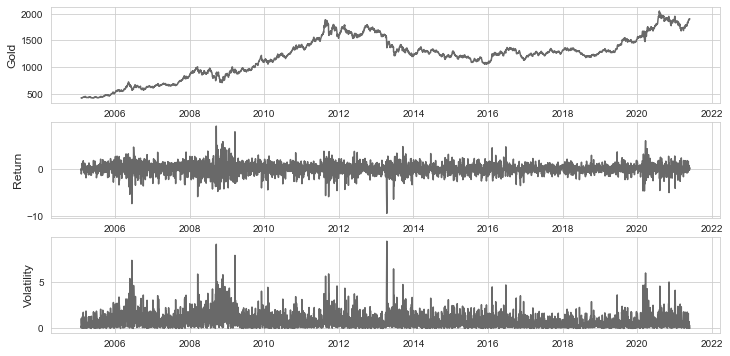

In [297]:
fig, axis = plt.subplots(3, figsize=(12,6))

axis[0].plot(df['Gold'], 'dimgray');
axis[0].set_ylabel('Gold', fontsize=12);

axis[1].plot(df['ret_Gold'], 'dimgray');
axis[1].set_ylabel('Return', fontsize=12);

axis[2].plot(df['ret_Gold'].abs(), 'dimgray');
axis[2].set_ylabel('Volatility', fontsize=12);

# Train & Test Split

In [298]:
len(df)

4071

In [341]:
size=3000

In [342]:
train, test = df[:size], df[size:]

In [343]:
s = len(train)
e = len(train) + len(test) - 1

# AR

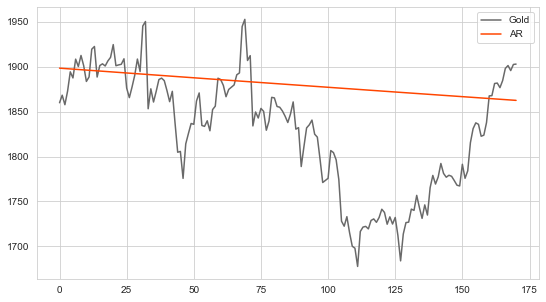

In [302]:
# Price predict
ar = ARIMA(train.Gold, order=(1,0,0))
result_ar = ar.fit()

pred_ar = result_ar.predict(start=s ,end=e).rename('AR')

test.Gold.reset_index(drop=True).plot(legend=True, figsize=(9,5), color='dimgray');
pred_ar.reset_index(drop=True).plot(legend=True, color='orangered');

In [303]:
#df.Gold.reset_index(drop=True).plot(legend=True, figsize=(9,5), color='dimgray');
#pred_ar.plot(legend=True, color='springgreen')
#plt.axvspan(pred_ar.index[0], pred_ar.index[-1], color='red', alpha=0.1);

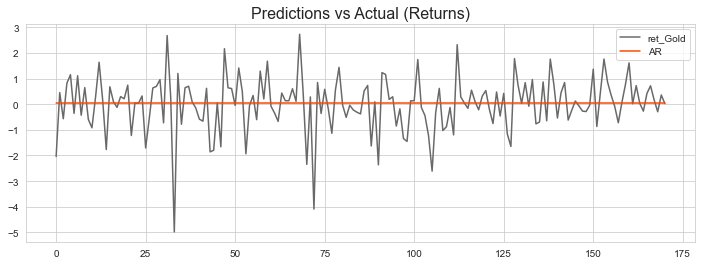

In [304]:
# Return predict
ar = ARIMA(train['ret_Gold'], order=(1,0,0))
result_ar = ar.fit()

pred_ar = result_ar.predict(start=s ,end=e).rename('AR')

test['ret_Gold'].reset_index(drop=True).plot(legend=True, figsize=(12,4), color='dimgray');
pred_ar.reset_index(drop=True).plot(legend=True, color='orangered');
plt.title('Predictions vs Actual (Returns)', size=16);

# MA

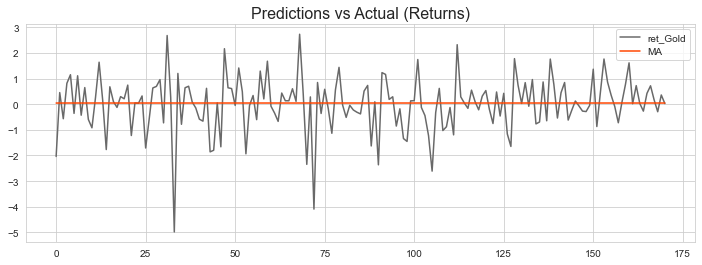

In [305]:
# Return predict
ma = ARIMA(train['ret_Gold'], order=(0,0,1))
result_ma = ma.fit()

pred_ma = result_ma.predict(start=s ,end=e).rename('MA')

test['ret_Gold'].reset_index(drop=True).plot(legend=True, figsize=(12,4), color='dimgray');
pred_ma.reset_index(drop=True).plot(legend=True, color='orangered');
plt.title('Predictions vs Actual (Returns)', size=16);

# ARMA

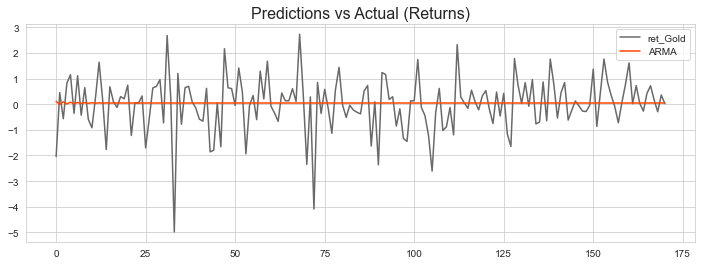

In [306]:
# Return predict
arma = ARIMA(train['ret_Gold'], order=(1,0,1))
result_arma = arma.fit()

pred_arma = result_arma.predict(start=s ,end=e).rename('ARMA')

test['ret_Gold'].reset_index(drop=True).plot(legend=True, figsize=(12,4), color='dimgray');
pred_arma.reset_index(drop=True).plot(legend=True, color='orangered');
plt.title('Predictions vs Actual (Returns)', size=16);

# ARMAX

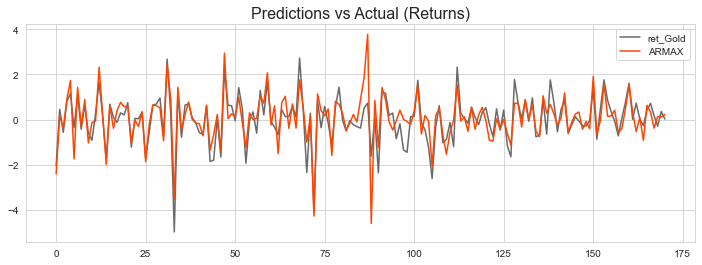

In [307]:
# Return predict
arma = ARIMA(train['ret_Gold'], exog=train[['ret_SP500', 'ret_DXY', 'ret_Silver']], order=(1,0,1))
result_arma = arma.fit()

pred_arma = result_arma.predict(start=s ,end=e, exog=test[['ret_SP500', 'ret_DXY', 'ret_Silver']]).rename('ARMAX')

test['ret_Gold'].reset_index(drop=True).plot(legend=True, figsize=(12,4), color='dimgray');
pred_arma.reset_index(drop=True).plot(legend=True, color='orangered');
plt.title('Predictions vs Actual (Returns)', size=16);

# SARMAX

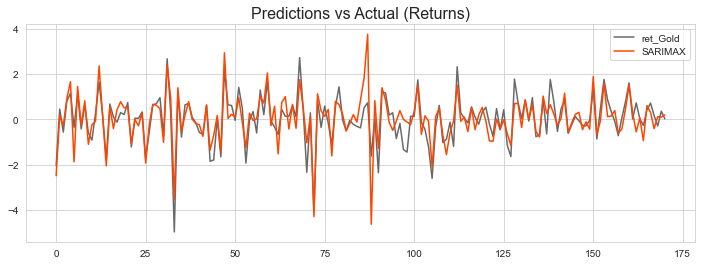

In [308]:
# Return predict
sarimax = SARIMAX(train['ret_Gold'], exog=train[['ret_SP500', 'ret_DXY', 'ret_Silver']], order=(3,0,4), seasonal_order=(3,0,2,5))
result_sarimax = sarimax.fit()

pred_sarimax = result_sarimax.predict(start=s ,end=e, exog=test[['ret_SP500', 'ret_DXY', 'ret_Silver']]).rename('SARIMAX')

test['ret_Gold'].reset_index(drop=True).plot(legend=True, figsize=(12,4), color='dimgray');
pred_sarimax.reset_index(drop=True).plot(legend=True, color='orangered');
plt.title('Predictions vs Actual (Returns)', size=16);

# Auto ARIMA

In [248]:
model_auto = auto_arima(train['ret_Gold'], exog=train[['ret_SP500', 'ret_DXY', 'ret_Silver']])

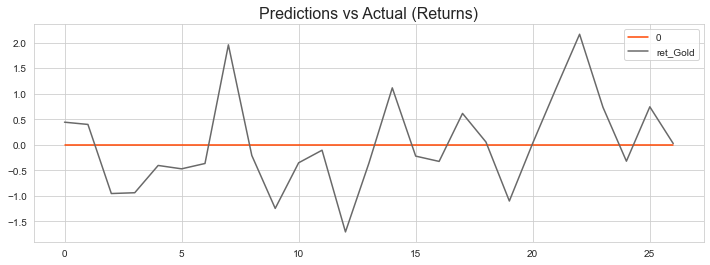

In [249]:
pd.DataFrame(model_auto.predict(n_periods = len(test), exog=test[['ret_SP500', 'ret_DXY', 'ret_Silver']])).plot(legend=True, color='orangered');
test['ret_Gold'].reset_index(drop=True).plot(legend=True, figsize=(12,4), color='dimgray');
plt.title('Predictions vs Actual (Returns)', size=16);

# Forecasting Volatility

In [344]:
start_date = test.index[0]

In [352]:
model_garch = arch_model(df['ret_Gold'], vol='GARCH', p=1, q=1, mean='constant', dist='Normal')
result_garch = model_garch.fit(last_obs=start_date, update_freq=8)

Iteration:      8,   Func. Count:     53,   Neg. LLF: 4642.453259707073
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4642.417299181134
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12


In [353]:
pred_garch = result_garch.forecast(horizon=1, align='target')

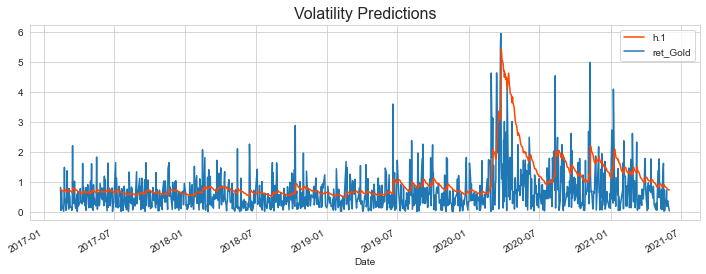

In [354]:
pred_garch.residual_variance[start_date:].plot(legend=True, figsize=(12,4), color='orangered', zorder=2);
test['ret_Gold'][start_date:].abs().plot(legend=True, zorder=1)
plt.title('Volatility Predictions', size=16);

# AD Fuller

In [ ]:
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("reject the null hypothesis")
        print("Data has no unit root, and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root, it is non-stationary")

In [ ]:
df['diff_1'] = diff(df['Close'], k_diff=1)

In [ ]:
adf_check(df['Close'].dropna())